In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Show all columns and avoid warnings
pd.set_option('display.max_columns', None)

In [ ]:
orders = pd.read_csv('orders.csv')
order_items = pd.read_csv('order_items.csv')
customers = pd.read_csv('customers.csv')
products = pd.read_csv('products.csv')
sellers = pd.read_csv('sellers.csv')
payments = pd.read_csv('payments.csv')
geolocation = pd.read_csv('geolocation.csv')

In [ ]:
# Merge step-by-step like SQL joins
df = orders.merge(customers, on='customer_id', how='left')
df = df.merge(order_items, on='order_id', how='left')
df = df.merge(products, on='product_id', how='left')
df = df.merge(sellers, on='seller_id', how='left')
df = df.merge(payments, on='order_id', how='left')

In [ ]:
# Convert date columns to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
df['order_delivered_customer_date'] = pd.to_datetime(df['order_delivered_customer_date'])

# Create new column: delivery time in days
df['delivery_time'] = (df['order_delivered_customer_date'] - df['order_purchase_timestamp']).dt.days

# Handle missing or invalid delivery times
df = df[df['delivery_time'].notna() & (df['delivery_time'] >= 0)]

# Fill missing numeric values
df['price'] = df['price'].fillna(df['price'].median())
df['freight_value'] = df['freight_value'].fillna(df['freight_value'].median())

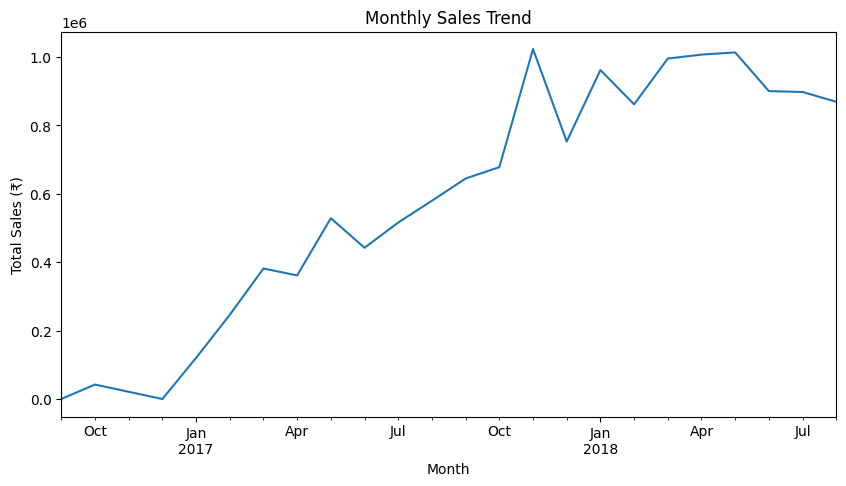

In [ ]:
df['order_month'] = df['order_purchase_timestamp'].dt.to_period('M')
sales_trend = df.groupby('order_month')['price'].sum()

plt.figure(figsize=(10,5))
sales_trend.plot()
plt.title("Monthly Sales Trend")
plt.xlabel("Month")
plt.ylabel("Total Sales (₹)")
plt.show()

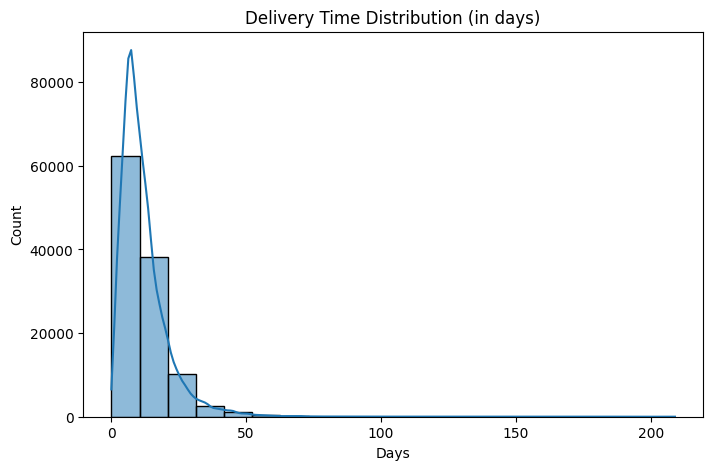

In [ ]:
plt.figure(figsize=(8,5))
sns.histplot(df['delivery_time'], bins=20, kde=True)
plt.title("Delivery Time Distribution (in days)")
plt.xlabel("Days")
plt.show()

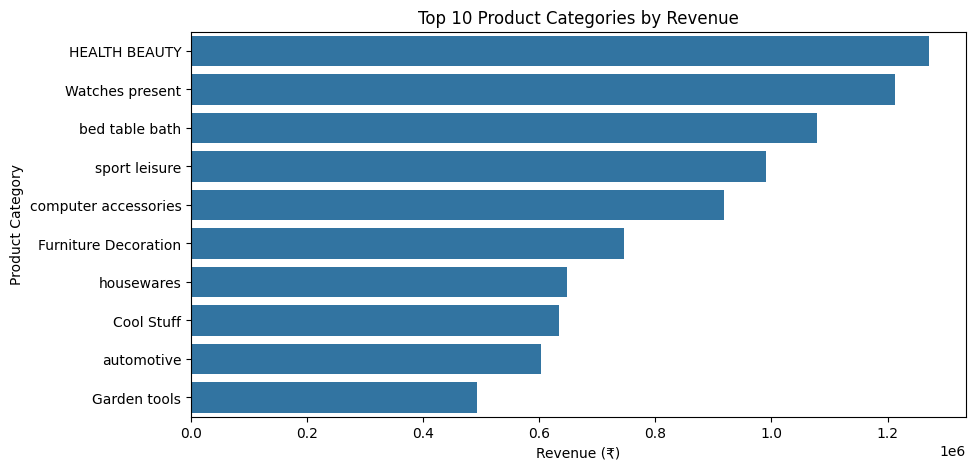

In [ ]:
top_categories = df.groupby('product category')['price'].sum().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title("Top 10 Product Categories by Revenue")
plt.xlabel("Revenue (₹)")
plt.ylabel("Product Category")
plt.show()

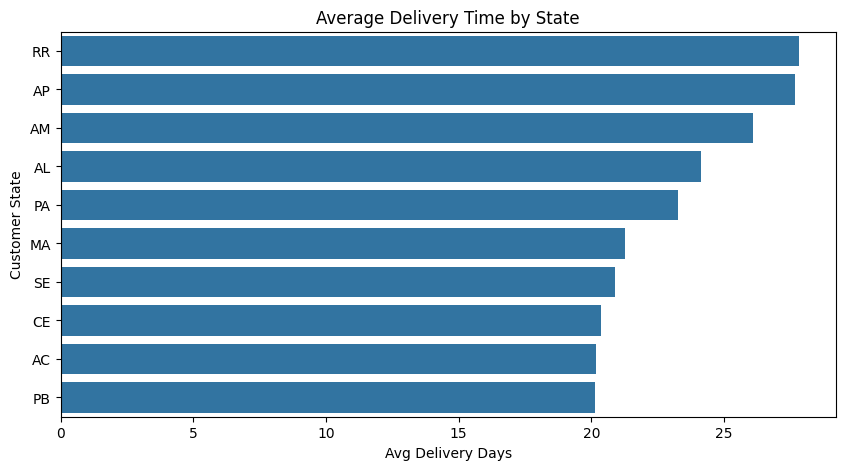

In [ ]:
region_delivery = df.groupby('customer_state')['delivery_time'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=region_delivery.values, y=region_delivery.index)
plt.title("Average Delivery Time by State")
plt.xlabel("Avg Delivery Days")
plt.ylabel("Customer State")
plt.show()


In [ ]:
# Average, median, and range of delivery times
print("Average Delivery Time:", df['delivery_time'].mean())
print("Median Delivery Time:", df['delivery_time'].median())
print("Longest Delivery Time:", df['delivery_time'].max())

Average Delivery Time: 12.019237288872276
Median Delivery Time: 10.0
Longest Delivery Time: 209.0


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Create target variable: delayed = 1 if delivery_time > median
df['is_delayed'] = np.where(df['delivery_time'] > df['delivery_time'].median(), 1, 0)

# Select features
X = df[['price', 'freight_value']]
y = df['is_delayed']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train Random Forest
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7133605702364395

Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73     12340
           1       0.69      0.70      0.69     10668

    accuracy                           0.71     23008
   macro avg       0.71      0.71      0.71     23008
weighted avg       0.71      0.71      0.71     23008



In [ ]:
df.to_csv("cleaned_ecommerce_data.csv", index=False)